In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import scipy as sp

from scipy import signal
from statsmodels.tsa.stattools import adfuller, acf
from scipy.fft import fft
from scipy.stats import chi2

# **1. Tratamiento de datos**

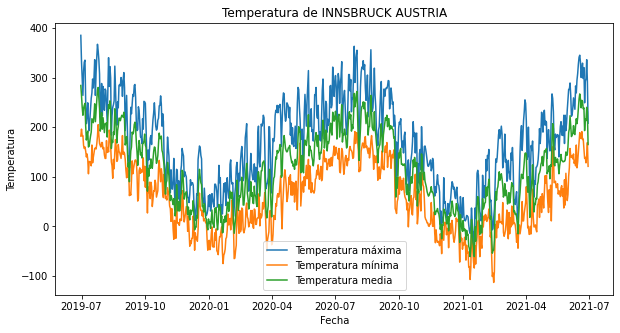

In [3]:
fpath1 = '/Users/valentinamoreno/Documents/SEMESTRE VIII/Procesos Estocásticos II/Parcial Nº3/Punto Nº2 Práctico/Data/Max_STAID000013.txt'
df1 = pd.read_csv(fpath1, sep='\s*,\s*', engine='python', skipinitialspace=True)
df1['DATE'] = pd.to_datetime(df1['DATE'], format='%Y%m%d')
df1.set_index("DATE", inplace=True, drop=True)


fpath2 = '/Users/valentinamoreno/Documents/SEMESTRE VIII/Procesos Estocásticos II/Parcial Nº3/Punto Nº2 Práctico/Data/Min_STAID000013.txt'
df2 = pd.read_csv(fpath2, sep='\s*,\s*', engine='python', skipinitialspace=True)
df2['DATE'] = pd.to_datetime(df2['DATE'], format='%Y%m%d')
df2.set_index("DATE", inplace=True, drop=True)

fpath3 = '/Users/valentinamoreno/Documents/SEMESTRE VIII/Procesos Estocásticos II/Parcial Nº3/Punto Nº2 Práctico/Data/Mean_STAID000013.txt'
df3 = pd.read_csv(fpath3, sep='\s*,\s*', engine='python', skipinitialspace=True)
df3['DATE'] = pd.to_datetime(df3['DATE'], format='%Y%m%d')
df3.set_index("DATE", inplace=True, drop=True)

idx = pd.date_range("2019-06-30", "2021-06-30", freq="D")
data_max = df1.loc[idx]
data_min = df2.loc[idx]
data_mean = df3.loc[idx]

data_mean['t'] = range(1, len(data_mean) + 1)
data_max['t'] = range(1, len(data_max) + 1)
data_min['t'] = range(1, len(data_min) + 1)

plt.figure(figsize=(10,5))
plt.plot(idx, data_max['TX'], label='Temperatura máxima')
plt.plot(idx, data_min['TN'], label='Temperatura mínima')  
plt.plot(idx, data_mean['TG'], label='Temperatura media')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.title('Temperatura de INNSBRUCK AUSTRIA')
plt.legend()
plt.show()

# **2. Pruebas de hipótesis**

## Media constante

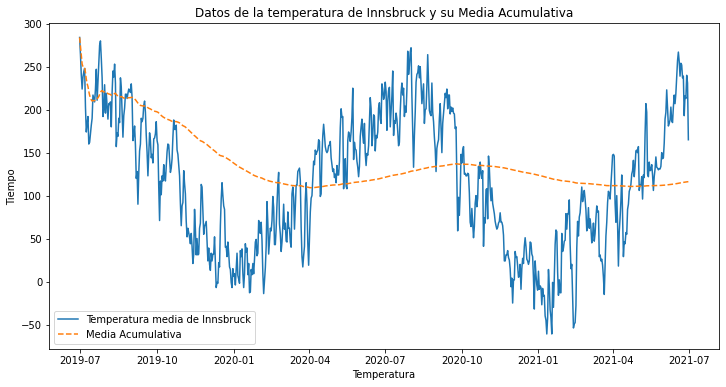

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

media_acumulativa = data_mean['TG'].cumsum() / range(1, len(data_mean['TG']) + 1)

plt.figure(figsize=(12, 6))
plt.plot(data_mean['TG'], label = "Temperatura media de Innsbruck")
plt.plot(media_acumulativa, label='Media Acumulativa', linestyle='--')
plt.title('Datos de la temperatura de Innsbruck y su Media Acumulativa')
plt.xlabel('Temperatura')
plt.ylabel('Tiempo')
plt.legend();


## Varianza acumulativa

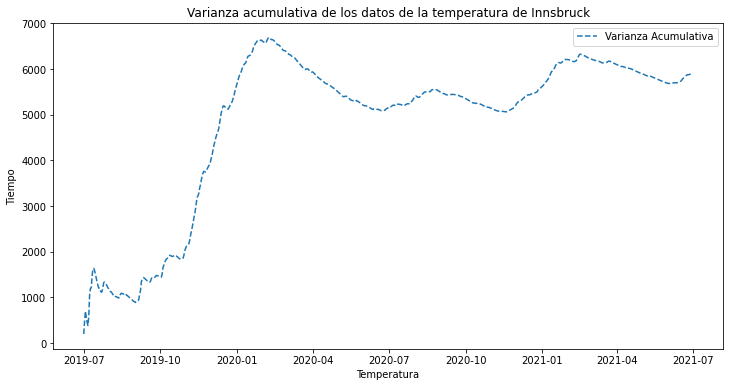

In [5]:
varianza_acumulativa = data_mean['TG'].expanding().var()

# Grafica la serie de tiempo original y la varianza acumulativa
plt.figure(figsize=(12, 6))
plt.plot(varianza_acumulativa, label='Varianza Acumulativa', linestyle='--')
plt.title('Varianza acumulativa de los datos de la temperatura de Innsbruck')
plt.xlabel('Temperatura')
plt.ylabel('Tiempo')
plt.legend()
plt.show()


In [6]:
import numpy as np
import pandas as pd

def calculate_hurst_exponent(time_series):
    if not isinstance(time_series, np.ndarray):
        time_series = np.array(time_series)
    lags = range(2, 100)
    tau = [np.sqrt(np.std(np.subtract(time_series[lag:], time_series[:-lag]))) for lag in lags]
    m = np.polyfit(np.log(lags), np.log(tau), 1)
    hurst_exponent = m[0]*2.0

    return hurst_exponent

hurst = calculate_hurst_exponent(data_mean['TG'])
print("Exponente de Hurst:", hurst)



Exponente de Hurst: 0.34008742628258115


## Estadísticas descriptivas

In [7]:
data_mean["TG"].describe()

count    732.000000
mean     116.207650
std       76.837637
min      -61.000000
25%       51.750000
50%      122.000000
75%      180.250000
max      284.000000
Name: TG, dtype: float64

# **3. Estimación de parámetros**

## Estimando $\mu (t)$

In [55]:
import statsmodels.api as sm

w = (2 * np.pi)/ 365

data_mean['sin_wt'] = np.sin(w * data_mean['t'])
data_mean['cos_wt'] = np.cos(w * data_mean['t'])

X = sm.add_constant(data_mean[['t', 'sin_wt', 'cos_wt']])
y = data_mean['TG']

model = sm.OLS(y, X).fit()

a1, a2, a3, a4 = model.params  
print(f"a1: {a1}, a2: {a2}, a3: {a3}, a4: {a4}") 

mu_t = lambda t: a1 + a2*t + (np.sqrt(a3**2 + a4**2))*np.sin(w*t - (np.arctan(a4/a3)-np.pi) )

a1: 126.55536375291265, a2: -0.028925435685317455, a3: 28.223096225904477, a4: 92.07133582064574


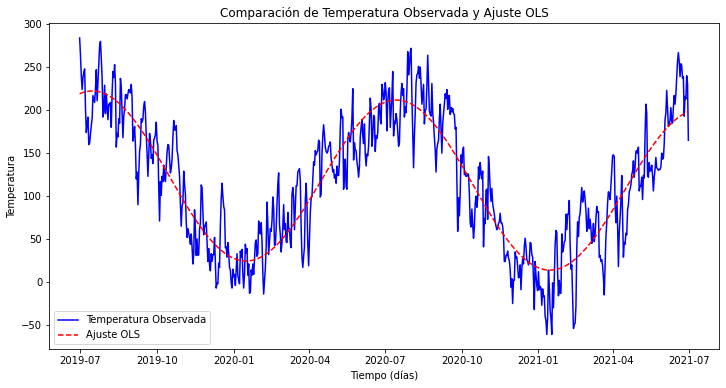

In [57]:
data_mean['mu (t)'] = data_mean['t'].apply(mu_t)

plt.figure(figsize=(12, 6))
plt.plot(idx, data_mean['TG'], label='Temperatura Observada', color='blue')
plt.plot(idx, data_mean['mu (t)'], label='Ajuste OLS', color='red', linestyle='--')
plt.title('Comparación de Temperatura Observada y Ajuste OLS')
plt.xlabel('Tiempo (días)')
plt.ylabel('Temperatura')
plt.legend()
plt.show()

## Estimando $\sigma$

$ \sigma_t =\frac{1}{N_{\mu}}\sum^{N_\mu-1}_{j=0}(T_{j+1}-T_j)^2$

In [71]:
enero = data_mean[data_mean.index.month == 1]
febrero = data_mean[data_mean.index.month == 2]
marzo = data_mean[data_mean.index.month == 3]
abril = data_mean[data_mean.index.month == 4]
mayo = data_mean[data_mean.index.month == 5]
junio = data_mean[data_mean.index.month == 6]
julio = data_mean[data_mean.index.month == 7]
agosto = data_mean[data_mean.index.month == 8]
septiembre =  data_mean[data_mean.index.month == 9]
octubre = data_mean[data_mean.index.month == 10]
noviembre = data_mean[data_mean.index.month == 11] 
diciembre = data_mean[data_mean.index.month == 12]

sigma =[]
for datos in [enero,febrero,marzo,abril,mayo,junio,julio,agosto,septiembre,octubre,noviembre,diciembre]:
    suma = 0
    for i in range(len(datos)-1):
        suma = (datos["TG"].iloc[i+1] - datos["TG"].iloc[i])**2
    sigma.append(suma/len(datos))

sigma


[0.25806451612903225,
 10.105263157894736,
 5.225806451612903,
 0.15,
 0.016129032258064516,
 71.40983606557377,
 4.129032258064516,
 10.903225806451612,
 33.75,
 0.016129032258064516,
 1.6666666666666667,
 0.5806451612903226]

## Estimando $\alpha$ 

$\alpha = -\log \frac{\sum^n_{i=1} Y_{i-1}*(T_i - T_i^m)}{\sum^n_{i=1} Y_{i-1}*(T_{i-1 }- T_{i-1}^m)}$

In [72]:
año = data_mean.loc[pd.date_range("2019-06-30", "2021-06-30", freq="D")]
año['Mes'] = año.index.month
año['Día'] = año.index.day
año['Año'] = año.index.year

año = año.sort_values(by=['Año', 'Mes', 'Día'])
sigma_mapping = {i+1: sigma[i] for i in range(12)}
año['sigma'] = año['Mes'].map(sigma_mapping)
año = año.drop(columns=['Mes', 'Día', 'Año'],)

acum1 = 0
acum2 = 0 

for i in range(1,len(año)):
    acum1 = acum1 + (((año.iloc[i-1]['mu (t)'] - año.iloc[i-1]['TG'])/(año.iloc[i-1]["sigma"]**2))*(año.iloc[i]['TG']-año.iloc[i]['mu (t)']))

for i in range(1,len(año)):
    acum2 = acum2 + (((año.iloc[i-1]['mu (t)'] - año.iloc[i-1]['TG'])/(año.iloc[i-1]["sigma"]**2))*(año.iloc[i-1]['TG']-año.iloc[i-1]['mu (t)']))

a = -np.log(acum1/acum2)

a

0.31261691416942156

# **4. Simulación del proceso de Ornstein–Uhlenbeck**

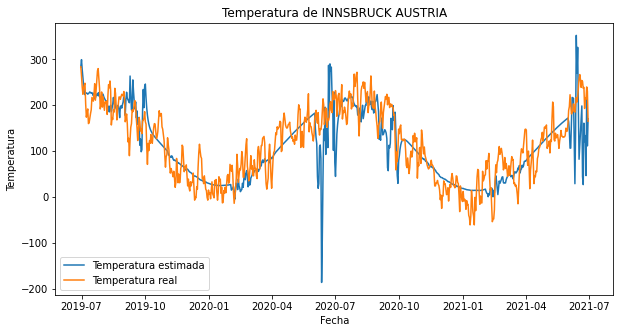

In [96]:
trayectorias = 1
N = len(data_mean)
dt = 1

t0 = data_mean.iloc[0]['TG']
         
fecha_inicio = pd.to_datetime('2019-06-30')
fechas = [fecha_inicio + pd.Timedelta(days=d) for d in range(N)]
sigma_t = np.array([sigma[fecha.month - 1] for fecha in fechas])

T_t = np.zeros((N, trayectorias))

T_m = data_mean["mu (t)"]
T_t[0, :] = t0  

for t in range(1, N):
    dB_t = np.random.normal(0, np.sqrt(dt), trayectorias)  
    T_t[t, :] = T_t[t - 1, :] + a * (T_m[t - 1] - T_t[t - 1]) * dt + sigma_t[t - 1]* dB_t

plt.figure(figsize=(10,5))
plt.plot(idx, T_t, label='Temperatura estimada')
plt.plot(idx, data_mean['TG'], label='Temperatura real')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.title('Temperatura de INNSBRUCK AUSTRIA')
plt.legend()
plt.show()

# **5. Pronóstico desde 01/7/2021-01/7/2023**

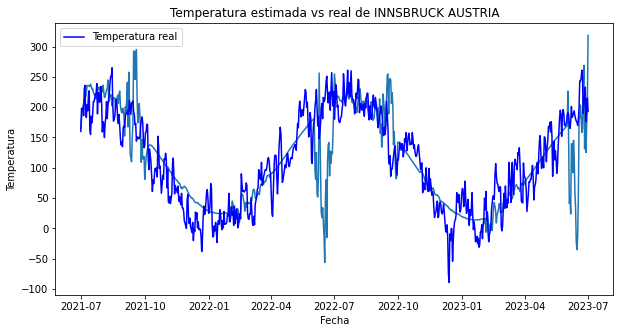

In [139]:
dates = pd.date_range("2021-07-01", "2023-07-01", freq="D")
trayectorias = 1
N = len(dates)
dt = 1

t0 = data_mean.iloc[-1]['TG']
         
fecha_inicio = pd.to_datetime('2021-07-01')
fechas = [fecha_inicio + pd.Timedelta(days=d) for d in range(N)]
sigma_t = np.array([sigma[fecha.month - 1] for fecha in fechas])

# \u(t)
w = 2 * np.pi / 365
#f = lambda t: a1 - a2 * t + a3 * np.sin(t * w) + a4 * np.cos(t * w)
t_values = np.arange(len(data_mean), len(data_mean) + len(dates))
mu_t = np.array([f(t) for t in t_values])

T_t = np.zeros((N, trayectorias))

T_m = data_mean["mu (t)"]
T_t[0, :] = t0  

for t in range(1, N):
    dB_t = np.random.normal(0, np.sqrt(dt), trayectorias)  
    T_t[t, :] = T_t[t - 1, :] + a * (T_m[t - 1] - T_t[t - 1]) * dt + sigma_t[t - 1]* dB_t

data_test = df3.loc[dates]

plt.figure(figsize=(10,5))
plt.plot(dates, T_t) #label='Temperatura estimada')
plt.plot(dates, data_test['TG'], label='Temperatura real', color='b')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.title('Temperatura estimada vs real de INNSBRUCK AUSTRIA')
plt.legend()
plt.show()

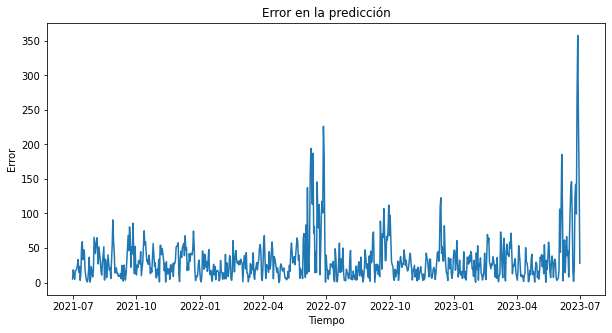

In [119]:
pronostico = T_t.flatten()
error = np.abs(data_test['TG']-pronostico)

plt.figure(figsize=(10,5))
plt.xlabel("Tiempo")
plt.ylabel("Error")
plt.title("Error en la predicción")
plt.plot(error)

In [115]:
np.mean(error)

32.09542339273652

In [121]:
df3

,STAID,SOUID,TG,Q_TG
DATE,,,,
1877-01-01,13,127858,40,0
1877-01-02,13,127858,35,0
1877-01-03,13,127858,45,0
1877-01-04,13,127858,65,0
1877-01-05,13,127858,70,0
...,...,...,...,...
2023-09-26,13,911121,156,0
2023-09-27,13,911121,164,0
2023-09-28,13,911121,169,0


In [122]:
idx = pd.date_range("2021-07-01", "2023-07-01", freq="D")

daticos = df3.loc[idx]

In [124]:
daticos.to_csv("Test.csv")

In [131]:
d=pd.read_csv("/Users/valentinamoreno/Documents/SEMESTRE VIII/Procesos Estocásticos II/Parcial Nº3/Punto Nº2 Práctico/Test.csv")
d=d.rename(columns={'Unnamed: 0':'DATE'})


In [133]:
d.to_csv("DAAAAATOOOS.csv", index=False)

In [134]:
pd.read_csv("/Users/valentinamoreno/Documents/SEMESTRE VIII/Procesos Estocásticos II/Parcial Nº3/Punto Nº2 Práctico/DAAAAATOOOS.csv")

,DATE,STAID,SOUID,TG,Q_TG
0,2021-07-01,13,119156,160,0
1,2021-07-02,13,119156,198,0
2,2021-07-03,13,119156,198,0
3,2021-07-04,13,119156,199,0
4,2021-07-05,13,119156,186,0
...,...,...,...,...,...
726,2023-06-27,13,911121,233,0
727,2023-06-28,13,911121,176,0
728,2023-06-29,13,911121,194,0
729,2023-06-30,13,911121,215,0
